# Brain Tumor Classification - Model Comparison

This notebook compares the baseline model explored in the previous section with more advanced models including using residual connections, and using Vision Transformers.

## 1. Setup and Imports

In [ ]:
#!/usr/bin/env python
# coding: utf-8
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam
import matplotlib.pyplot as plt
import timm

In [ ]:
# import our own modules
import sys
sys.path.append('../src')  # Add the src directory to the Python path

# import data
from config.data import data_setup, data_loader
from models.vision_transformer import run_training
from utils.prediction import analyze_predictions, train_model
from models.cnn import BrainTumorCNN, BrainTumorCNN_RN

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

## 2. Data Loading and Preprocessing

In [ ]:
# Load data and data_loaders
train_set, test_set, label_conversion_dict = data_setup()
train_loader, test_loader = data_loader(train_set, test_set)

# Extract the class labels from the dictionary keys
class_labels = list(label_conversion_dict.keys())[:4]

# 3. Model training

We start with our baseline model

In [ ]:
# Initialize model
model_cnn = BrainTumorCNN().to(device)
print(model_cnn)

history = train_model(
    model=model_cnn,
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=10
)

# Now you can access the following:
train_loss_list = history['train_loss_list']
test_loss_list = history['test_loss_list']
accuracy_list = history['accuracy_list']
cnn_all_predictions = history['all_predictions']
cnn_all_true_labels = history['all_true_labels']

In [ ]:
# Analyse and save predictions
analyze_predictions(cnn_all_predictions, cnn_all_true_labels)

# Create a directory called "results" if it doesn't already exist
os.makedirs('results', exist_ok=True)

# Save the lists as numpy arrays for easy reloading
np.save('results/cnn_train_loss_list.npy', np.array(train_loss_list))
np.save('results/cnn_test_loss_list.npy', np.array(test_loss_list))
np.save('results/cnn_accuracy_list.npy', np.array(accuracy_list))

# Save predictions and true labels as pickle files (more efficient for storing lists of lists)
with open('results/cnn_all_predictions.pkl', 'wb') as f:
    pickle.dump(cnn_all_predictions, f)

with open('results/cnn_all_true_labels.pkl', 'wb') as f:
    pickle.dump(cnn_all_true_labels, f)

print("All results have been successfully saved in the 'results/' directory.")


Now we try the same CNN but with residual connections.

In [ ]:
model_cnn_res = BrainTumorCNN_RN().to(device)
print(model_cnn_res)

history = train_model(
    model=model_cnn_res,
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=10
)

# Now you can access the following:
train_loss_list = history['train_loss_list']
test_loss_list = history['test_loss_list']
accuracy_list = history['accuracy_list']
cnn_res_all_predictions = history['all_predictions']
cnn_res_all_true_labels = history['all_true_labels']

In [ ]:
# Analyse and save predictions
analyze_predictions(cnn_res_all_predictions, cnn_res_all_true_labels)

# Create a directory called "results" if it doesn't already exist
os.makedirs('results', exist_ok=True)

# Save the lists as numpy arrays for easy reloading
np.save('results/cnn_res_train_loss_list.npy', np.array(train_loss_list))
np.save('results/cnn_res_test_loss_list.npy', np.array(test_loss_list))
np.save('results/cnn_res_accuracy_list.npy', np.array(accuracy_list))

# Save predictions and true labels as pickle files (more efficient for storing lists of lists)
with open('results/cnn_res_all_predictions.pkl', 'wb') as f:
    pickle.dump(cnn_res_all_predictions, f)

with open('results/cnn_res_all_true_labels.pkl', 'wb') as f:
    pickle.dump(cnn_res_all_true_labels, f)

print("All results have been successfully saved in the 'results/' directory.")


We use a pre-trained ViT, else we would overfit the data since ViT need a lot of data and we only have a few thousand images

In [ ]:
# Load a pre-trained Vision Transformer model
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=4)  # Adjust 'num_classes' to your task
vit_model.to(device)
vit_model.train()  # Set model to training mode

# Print the model architecture
print(vit_model)

In [ ]:
train_set_vit, test_set_vit, label_conversion_dict = data_setup(vision_transformer=True)
train_loader_vit, test_loader_vit = data_loader(train_set, test_set)

In [ ]:
# Standard optimizer setup
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_model.parameters(), lr=0.001)

# Set number of epochs
num_epochs = 10

# Run training
train_loss_list, test_loss_list, accuracy_list, vit_all_predictions, vit_all_true_labels = run_training(
    vit_model, train_loader_vit, test_loader_vit, optimizer, None, criterion, num_epochs, device, fine_tuning=False
)


SyntaxError: invalid syntax (<ipython-input-18-6f8348c18d5b>, line 28)

In [ ]:
# Analyse and save predictions
analyze_predictions(vit_all_predictions, vit_all_true_labels)

# Create a directory called "results" if it doesn't already exist
os.makedirs('results', exist_ok=True)

# Save the lists as numpy arrays for easy reloading
np.save('results/vit_train_loss_list.npy', np.array(train_loss_list))
np.save('results/vit_test_loss_list.npy', np.array(test_loss_list))
np.save('results/vit_accuracy_list.npy', np.array(accuracy_list))

# Save predictions and true labels as pickle files (more efficient for storing lists of lists)
with open('results/vit_all_predictions.pkl', 'wb') as f:
    pickle.dump(vit_all_predictions, f)

with open('results/vit_all_true_labels.pkl', 'wb') as f:
    pickle.dump(vit_all_true_labels, f)

print("All results have been successfully saved in the 'results/' directory.")



### Now we explore a second version of the ViT model where we unfreeze the last Transformation block.

Key extras about this model
 - Pre-trained Model: Like the first model, this one starts with a pre-trained Vision Transformer, but only the last transformer block and the classification head are unfrozen.
 - Fine-tuning: The last transformer block (blocks.11) and the normalization layers are unfrozen. This allows the model to adjust the more complex representations in the deeper layers of the transformer to fit your specific task.
 - (There are 12 transformer blocks in total)

In [ ]:
# # Load a pre-trained Vision Transformer model
vit_model_ft = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=4)  # Adjust 'num_classes' to your task

# Fine-tuning setup (assuming you want to unfreeze specific layers)
for name, param in vit_model_ft.named_parameters():
    if 'blocks.11' in name or 'norm' in name or 'head' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Add Dropout layer before final classification layer
vit_model_ft.head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(vit_model_ft.head.in_features, 4)
)

vit_model_ft.to(device)
vit_model_ft.train()

# Print the model architecture
print(vit_model_ft)

# Optimizer setup with different learning rates for head and other layers
head_params = list(vit_model_ft.head.parameters())
other_params = [p for p in vit_model_ft.parameters() if p not in set(head_params)]

optimizer = Adam([
    {'params': head_params, 'lr': 0.001},
    {'params': other_params, 'lr': 0.0001}
])

# Scheduler setup if needed
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Run training
vit_ft_train_loss_list, vit_ft_test_loss_list, vit_ft_accuracy_list, vit_ft_all_predictions, vit_ft_all_true_labels = run_training(
    vit_model_ft, train_loader_vit, test_loader_vit, optimizer, scheduler, criterion, num_epochs, device, fine_tuning=True
)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
# Analyse and save results
analyze_predictions(vit_ft_all_predictions, vit_ft_all_true_labels)

# Save the lists as numpy arrays for easy reloading
np.save('results/vit_ft_train_loss_list.npy', np.array(train_loss_list))
np.save('results/vit_ft_val_loss_list.npy', np.array(test_loss_list))
np.save('results/vit_ft_accuracy_list.npy', np.array(accuracy_list))

# Save predictions and true labels as pickle files (more efficient for storing lists of lists)
with open('results/vit_ft_all_predictions.pkl', 'wb') as f:
    pickle.dump(vit_ft_all_predictions, f)

with open('results/vit_ft_all_true_labels.pkl', 'wb') as f:
    pickle.dump(vit_ft_all_true_labels, f)

print("All fine-tuned results have been successfully saved in the 'results/' directory.")


All fine-tuned results have been successfully saved in the 'results/' directory.


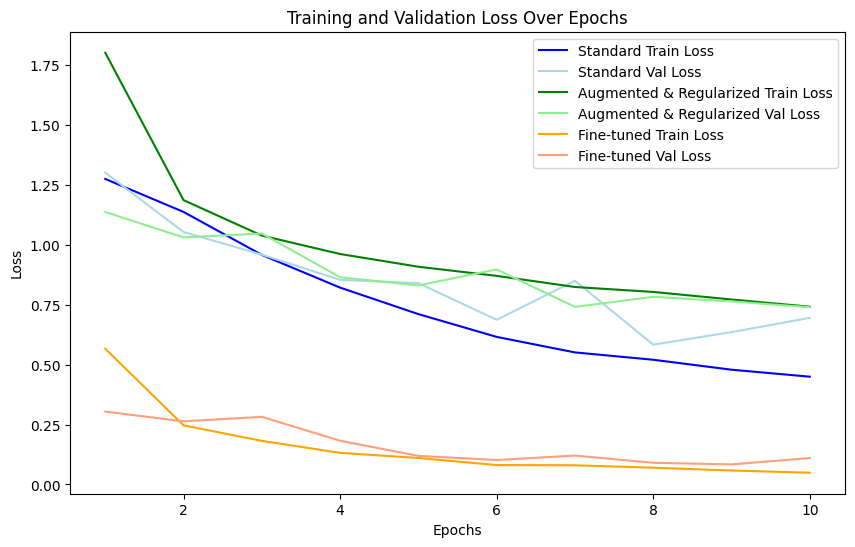

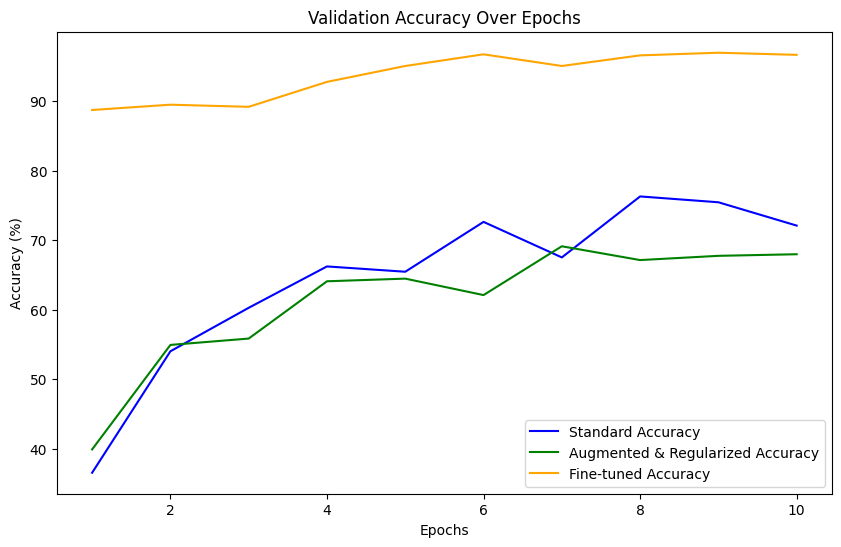

In [ ]:
# Load the results
standard_train_loss = np.load('/content/results/train_loss_list.npy')
standard_val_loss = np.load('/content/results/val_loss_list.npy')
standard_accuracy = np.load('/content/results/accuracy_list.npy')

fine_tuned_train_loss = np.load('/content/results/train_loss_list_finetuned.npy')
fine_tuned_val_loss = np.load('/content/results/val_loss_list_finetuned.npy')
fine_tuned_accuracy = np.load('/content/results/accuracy_list_finetuned.npy')

# Load predictions and true labels using pickle
with open('/content/results/vit_all_predictions.pkl', 'rb') as f:
    standard_predictions = pickle.load(f)

with open('/content/results/vit_ft_all_predictions.pkl', 'rb') as f:
    fine_tuned_predictions = pickle.load(f)

with open('/content/results/vit_all_true_labels.pkl', 'rb') as f:
    standard_true_labels = pickle.load(f)

with open('/content/results/vit_ft_all_true_labels.pkl', 'rb') as f:
    fine_tuned_true_labels = pickle.load(f)


# Plotting the results

# 1. Line chart comparing training loss and validation loss for each epoch
epochs = range(1, len(standard_train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, standard_train_loss, label='Standard Train Loss', color='blue')
plt.plot(epochs, standard_val_loss, label='Standard Val Loss', color='lightblue')

plt.plot(epochs, fine_tuned_train_loss, label='Fine-tuned Train Loss', color='orange')
plt.plot(epochs, fine_tuned_val_loss, label='Fine-tuned Val Loss', color='#FFA07A')  # Use a valid color code

plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 3. Line chart comparing validation accuracy for each epoch
plt.figure(figsize=(10, 6))
plt.plot(epochs, standard_accuracy, label='Standard Accuracy', color='blue')
plt.plot(epochs, fine_tuned_accuracy, label='Fine-tuned Accuracy', color='orange')

plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()


In [ ]:
# If you want to download the results locally

import shutil
from google.colab import files

# Compress the 'results' folder into a zip file
shutil.make_archive('/content/results', 'zip', '/content/results')

# Create a download link for the zip file
files.download('/content/results.zip')